In [24]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, operator
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [25]:
load_dotenv()

True

In [26]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

In [27]:
class EssayEvaluationSchema(BaseModel):
    feedback: str = Field(description="detailed feedback on the essay")
    score: int = Field(description="score for the essay (0-10)", ge=0, le=10)

# class EssayEvaluationOutput(BaseModel):
#     grammar_score: int = Field(..., description="Score for grammar (0-10)")
#     coherence_score: int = Field(..., description="Score for coherence (0-10)")
#     relevance_score: int = Field(..., description="Score for relevance (0-10)")
#     overall_score: int = Field(..., description="Overall score (0-10)")

In [28]:
structured_model = model.with_structured_output(EssayEvaluationSchema)

In [36]:
essay = """ ## The Role of Artificial Intelligence in Business

Artificial Intelligence, commonly known as AI, is transforming how businesses operate, compete, and grow. It refers to computer systems that can perform tasks typically requiring human intelligence, such as learning from data, recognizing patterns, understanding language, and making decisions. In modern business environments, AI is no longer optional but increasingly a strategic necessity.

One of the most important roles of AI in business is improving decision making. According to a report by McKinsey & Company, organizations that effectively use AI-driven analytics can significantly enhance performance by extracting insights from large volumes of data. Machine learning models can analyze customer behavior, forecast demand, detect anomalies, and support data-driven strategies that reduce uncertainty and risk.

AI also plays a major role in operational efficiency. Technologies such as robotic process automation automate repetitive administrative tasks like data entry, invoice processing, and report generation. This reduces human error and allows employees to focus on higher value activities. According to Deloitte, intelligent automation can improve productivity while lowering operational costs when implemented strategically.

Customer experience is another area where AI delivers strong impact. AI powered chatbots and virtual assistants provide 24 hour support, personalized recommendations, and faster response times. Research from IBM shows that AI chatbots can handle a large percentage of routine customer inquiries, helping companies reduce service costs while maintaining service quality.

In marketing and sales, AI enables predictive targeting and personalization. Algorithms analyze browsing history, purchase behavior, and engagement patterns to deliver tailored advertisements and product suggestions. According to PwC, AI is expected to contribute significantly to global economic growth through productivity gains and consumer personalization.

However, the adoption of AI also raises ethical and governance concerns. Businesses must ensure data privacy, transparency, and fairness in algorithmic decisions. Regulatory frameworks such as the EU AI Act are emerging to guide responsible AI deployment. Companies that balance innovation with ethical responsibility are more likely to build long term trust.

In conclusion, AI plays a transformative role in business by enhancing decision making, increasing efficiency, improving customer experience, and driving innovation. As AI technologies continue to evolve, businesses that strategically integrate them while maintaining ethical standards will gain a competitive advantage in the global marketplace.
"""

In [37]:
essay2 = """The Role of Technology in Society

Technology is very important in society today. It has changed many things and makes life better in many ways. People use technology every day for different reasons. For example, they use phones, computers, and the internet. This shows that technology is useful.

One reason technology is good is because it helps people communicate. Before, people had to send letters, but now they can send messages instantly. This is faster and better. Also, technology helps in education. Students can search for information online and learn new things. This proves that technology improves knowledge.

However, technology can also be bad sometimes. Some people spend too much time on their phones. This is not healthy. It can also cause problems like cyberbullying. But overall, technology is still good because it makes life easier.

In conclusion, technology plays a big role in society. It has advantages and disadvantages, but the advantages are more important. Technology will continue to grow in the future and help people even more.

"""

In [41]:
essay3 = """The Transformative Role of Technology in Modern Society

Technology has evolved from being a collection of tools that simplify tasks into a foundational force that shapes economies, cultures, and individual identities. In the twenty-first century, it does not merely support society; it actively structures how people communicate, learn, govern, and even think. While technology introduces complex ethical and social challenges, its transformative capacity lies in how effectively societies adapt and regulate its integration.

One of the most profound impacts of technology is on communication. Digital platforms have collapsed geographical barriers, enabling real-time interaction across continents. This shift has redefined global collaboration, allowing businesses to operate across time zones and individuals to sustain relationships regardless of physical distance. However, the transformation extends beyond speed and convenience. The rise of algorithm-driven content distribution has altered how information is consumed, often reinforcing existing beliefs through echo chambers. Thus, while technology enhances connectivity, it simultaneously reshapes public discourse in ways that require critical awareness and responsible governance.

Technology has also revolutionized education and knowledge production. Online learning platforms, open-access journals, and artificial intelligence tools have democratized access to information. A student in a remote region can now access lectures from leading universities, narrowing educational inequalities that once seemed insurmountable. Yet, this democratization introduces new disparities, particularly in digital literacy and access to infrastructure. The mere availability of information does not guarantee meaningful learning. Therefore, the true value of educational technology lies not only in accessibility but in fostering critical thinking and equitable implementation.

In the economic sphere, automation and artificial intelligence are transforming labor markets. Repetitive and manual tasks are increasingly performed by machines, leading to higher efficiency and productivity. While this shift can generate economic growth, it also raises concerns about job displacement and the future of work. Historically, technological revolutions have created new industries even as they rendered others obsolete. The key challenge lies in proactive reskilling and policy frameworks that ensure workers transition effectively rather than being marginalized. Technology, in this context, is neither inherently beneficial nor harmful; its societal outcome depends on strategic planning and ethical foresight.

Moreover, technological innovation has amplified humanity’s capacity to address global challenges. Advancements in renewable energy systems, medical diagnostics, and data analytics have improved responses to climate change and public health crises. For example, rapid vaccine development and global data sharing during pandemics demonstrate how interconnected technological systems can save lives. However, these same systems raise issues of privacy, surveillance, and data security. Balancing innovation with ethical safeguards is therefore essential.

In conclusion, technology is not simply a tool that improves convenience; it is a transformative force that redefines social structures, economic systems, and human interaction. Its impact is multidimensional, encompassing communication, education, labor, and global problem-solving. The ultimate measure of its success will not be technological sophistication alone, but society’s ability to harness its power responsibly, equitably, and ethically.
"""

In [30]:
# prompt = f"Evaluate the following essay and provide detailed feedback along with a score from 0 to 10:\n\n{essay}"
# result = structured_model.invoke(prompt)
# print(result.score)
# print(result.feedback)


In [31]:
class EvalutionState(TypedDict):

    essay: str
    language_feedback: str
    clarity_feedback: str
    analysis_feedback: str
    overall_feedback: str

    individual_scores: Annotated[list[int], operator.add]
    overall_score: float

In [32]:
def evaluate_language(state: EvalutionState) -> EvalutionState:
    prompt = f"Evaluate the language quality used in the following essay and provide detailed feedback along with a score from 0 to 10:\n\n{state['essay']}"
    result = structured_model.invoke(prompt)
    return {'language_feedback': result.feedback, 'individual_scores': [result.score]}

def evaluate_clarity(state: EvalutionState) -> EvalutionState:
    prompt = f"Evaluate the clarity of the following essay and provide detailed feedback along with a score from 0 to 10:\n\n{state['essay']}"
    result = structured_model.invoke(prompt)
    return {'clarity_feedback': result.feedback, 'individual_scores': [result.score]}

def evaluate_analysis(state: EvalutionState) -> EvalutionState:
    prompt = f"Evaluate the depth of analysis in the following essay and provide detailed feedback along with a score from 0 to 10:\n\n{state['essay']}"
    result = structured_model.invoke(prompt)
    return {'analysis_feedback': result.feedback, 'individual_scores': [result.score]}

def final_evaluation(state: EvalutionState) -> EvalutionState:
    prompt = f"Based on the following feedback, provide an overall summarised evaluation of the essay along with a final score from 0 to 10:\n\nLanguage Feedback: {state['language_feedback']}\nClarity Feedback: {state['clarity_feedback']}\nAnalysis Feedback: {state['analysis_feedback']}"
    result = model.invoke(prompt).content
    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])
    return {'overall_feedback': result, 'overall_score': avg_score}

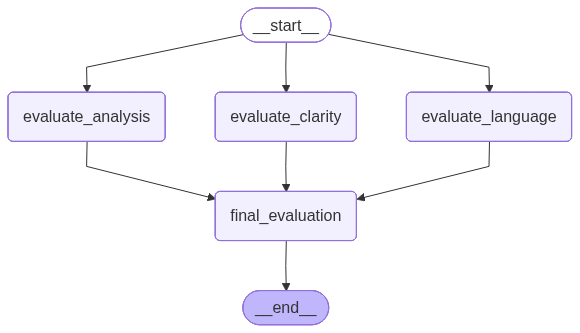

In [33]:
graph = StateGraph(EvalutionState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_clarity', evaluate_clarity)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('final_evaluation', final_evaluation)

#edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_clarity')
graph.add_edge(START, 'evaluate_analysis')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_clarity', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('final_evaluation', END)

workflow = graph.compile()

from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
#Bad essay
initial_state = {
    'essay': essay2
}

workflow.invoke(initial_state)

/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EssayEvaluationSchema(fee...\nScore: 4/10", score=4), input_type=EssayEvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EssayEvaluationSchema(fee... \n\nScore: 5', score=5), input_type=EssayEvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(

{'essay': 'The Role of Technology in Society\n\nTechnology is very important in society today. It has changed many things and makes life better in many ways. People use technology every day for different reasons. For example, they use phones, computers, and the internet. This shows that technology is useful.\n\nOne reason technology is good is because it helps people communicate. Before, people had to send letters, but now they can send messages instantly. This is faster and better. Also, technology helps in education. Students can search for information online and learn new things. This proves that technology improves knowledge.\n\nHowever, technology can also be bad sometimes. Some people spend too much time on their phones. This is not healthy. It can also cause problems like cyberbullying. But overall, technology is still good because it makes life easier.\n\nIn conclusion, technology plays a big role in society. It has advantages and disadvantages, but the advantages are more impo

In [ ]:
#Good essay
initial_state = {
    'essay': essay
}

workflow.invoke(initial_state)

/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EssayEvaluationSchema(fee...ignificantly.', score=7), input_type=EssayEvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EssayEvaluationSchema(fee...d engagement.', score=8), input_type=EssayEvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(

{'essay': ' ## The Role of Artificial Intelligence in Business\n\nArtificial Intelligence, commonly known as AI, is transforming how businesses operate, compete, and grow. It refers to computer systems that can perform tasks typically requiring human intelligence, such as learning from data, recognizing patterns, understanding language, and making decisions. In modern business environments, AI is no longer optional but increasingly a strategic necessity.\n\nOne of the most important roles of AI in business is improving decision making. According to a report by McKinsey & Company, organizations that effectively use AI-driven analytics can significantly enhance performance by extracting insights from large volumes of data. Machine learning models can analyze customer behavior, forecast demand, detect anomalies, and support data-driven strategies that reduce uncertainty and risk.\n\nAI also plays a major role in operational efficiency. Technologies such as robotic process automation autom

In [ ]:
#better essay
initial_state = {
    'essay': essay3
}

workflow.invoke(initial_state)

/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EssayEvaluationSchema(fee...ven stronger.", score=8), input_type=EssayEvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EssayEvaluationSchema(fee... \n\nScore: 8", score=8), input_type=EssayEvaluationSchema])
  return self.__pydantic_serializer__.to_python(
/Users/junaeidshoaib/Documents/LangGraph/myenv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(

{'essay': 'The Transformative Role of Technology in Modern Society\n\nTechnology has evolved from being a collection of tools that simplify tasks into a foundational force that shapes economies, cultures, and individual identities. In the twenty-first century, it does not merely support society; it actively structures how people communicate, learn, govern, and even think. While technology introduces complex ethical and social challenges, its transformative capacity lies in how effectively societies adapt and regulate its integration.\n\nOne of the most profound impacts of technology is on communication. Digital platforms have collapsed geographical barriers, enabling real-time interaction across continents. This shift has redefined global collaboration, allowing businesses to operate across time zones and individuals to sustain relationships regardless of physical distance. However, the transformation extends beyond speed and convenience. The rise of algorithm-driven content distributi